# Lecture 7 - Recommendation Engines


In this lecture we will cover the basics of Recommendation Engines. We will cover

1. User/User Pairings
2.  Item/Item Pairings
3. Graph Diffusion / Random Walks

We will use a public dataset of band preferences taken from a radio show in Germany - LastFM. 

In [1]:
# read data into a DataFrame
import pandas as pd
import pylab as plt
import seaborn
from sklearn.linear_model import LinearRegression
import numpy.random as nprnd
import random
import json
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cosine
from sklearn.metrics import pairwise_distances
pd.set_option('display.max_columns', 500)
%matplotlib inline

In [2]:
df=pd.read_csv('http://www.salemmarafi.com/wp-content/uploads/2014/04/lastfm-matrix-germany.csv')

In [3]:
X = df.drop(['user'],1)

# 1. Understanding the data

We see below the common format of having (user, items_liked) 

In [4]:
df.head()

,user,a perfect circle,abba,ac/dc,adam green,aerosmith,afi,air,alanis morissette,alexisonfire,alicia keys,all that remains,amon amarth,amy macdonald,amy winehouse,anti-flag,aphex twin,apocalyptica,arcade fire,arch enemy,arctic monkeys,as i lay dying,atb,atreyu,audioslave,avril lavigne,babyshambles,bad religion,beastie boys,beatsteaks,beck,beirut,belle and sebastian,beyonce,billy talent,bjork,black eyed peas,black sabbath,blind guardian,blink-182,bloc party,bloodhound gang,blur,boards of canada,bob dylan,bob marley,bob marley & the wailers,breaking benjamin,bright eyes,bring me the horizon,britney spears,bruce springsteen,bullet for my valentine,caliban,cascada,cat power,children of bodom,chimaira,christina aguilera,clueso,cocorosie,coldplay,crystal castles,cypress hill,daft punk,damien rice,dark tranquillity,david bowie,david guetta,death cab for cutie,deep purple,deftones,deichkind,depeche mode,dido,die apokalyptischen reiter,die toten hosen,digitalism,dimmu borgir,dire straits,disturbed,dream theater,dredg,dropkick murphys,duffy,editors,eels,elliott smith,eluveitie,elvis presley,eminem,ensiferum,enter shikari,equilibrium,eric clapton,evanescence,faithless,fall out boy,farin urlaub,feist,finntroll,flogging molly,flyleaf,foo fighters,frank sinatra,franz ferdinand,funeral for a friend,genesis,gentleman,godsmack,goldfrapp,good charlotte,gorillaz,green day,groove coverage,guano apes,guns n roses,hammerfall,hans zimmer,hatebreed,heaven shall burn,him,hoobastank,hot chip,howard shore,in extremo,in flames,incubus,interpol,iron maiden,jack johnson,james blunt,james morrison,jamiroquai,jason mraz,jay-z,jimi hendrix,jimmy eat world,johnny cash,jose gonzalez,joy division,judas priest,justice,justin timberlake,kaiser chiefs,kanye west,kate nash,katie melua,katy perry,keane,kelly clarkson,killswitch engage,kings of convenience,kings of leon,korpiklaani,kreator,lacuna coil,lady gaga,led zeppelin,lenny kravitz,leona lewis,lily allen,limp bizkit,linkin park,lostprophets,machine head,madonna,mando diao,manowar,manu chao,maria mena,marilyn manson,massive attack,metallica,mgmt,michael jackson,mika,millencolin,misfits,moby,modest mouse,mogwai,morcheeba,motorhead,muse,my chemical romance,nada surf,nelly furtado,nickelback,nightwish,nine inch nails,nirvana,nofx,norah jones,nouvelle vague,oasis,oomph!,opeth,panic at the disco,papa roach,paramore,parkway drive,pearl jam,peter fox,pink,pink floyd,placebo,porcupine tree,portishead,queen,queens of the stone age,r.e.m.,radiohead,rage against the machine,rammstein,ramones,razorlight,red hot chili peppers,regina spektor,rihanna,rise against,rob zombie,robbie williams,schandmaul,scooter,seeed,seether,serj tankian,silverstein,simple plan,slayer,slipknot,snow patrol,soilwork,sonata arctica,sonic syndicate,staind,stars,stone sour,subway to sally,sufjan stevens,sum 41,system of a down,tegan and sara,tenacious d,the beatles,the chemical brothers,the clash,the cure,the decemberists,the doors,the fratellis,the fray,the hives,the killers,the kooks,the libertines,the national,the notwist,the offspring,the postal service,the prodigy,the pussycat dolls,the rolling stones,the shins,the smashing pumpkins,the smiths,the streets,the strokes,the subways,the ting tings,the used,the white stripes,the wombats,thievery corporation,three days grace,timbaland,tom waits,tool,tori amos,travis,trivium,u2,underoath,volbeat,yann tiersen
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

In [5]:
X.shape

(1257, 285)

Therefore we have 1257 users and 285 bands.

# 2. Collaborative Filtering 

In [6]:
user_user = 1-pairwise_distances(X, metric="cosine")
item_item = 1-pairwise_distances(X.T, metric="cosine")

In [7]:
user_user.shape

(1257, 1257)

In [17]:
item_item.shape

(285, 285)

In [12]:
df_items = pd.DataFrame(item_item,columns=X.columns,index=X.columns)
df_users = pd.DataFrame(user_user,columns=df['user'].values,index=df['user'].values)

## 2.1 Item/item based collaborative filtering

If we have $285$ items, then the collaborative matrix will be $285 \times 285$ 

In [13]:
df_items.head()

,a perfect circle,abba,ac/dc,adam green,aerosmith,afi,air,alanis morissette,alexisonfire,alicia keys,all that remains,amon amarth,amy macdonald,amy winehouse,anti-flag,aphex twin,apocalyptica,arcade fire,arch enemy,arctic monkeys,as i lay dying,atb,atreyu,audioslave,avril lavigne,babyshambles,bad religion,beastie boys,beatsteaks,beck,beirut,belle and sebastian,beyonce,billy talent,bjork,black eyed peas,black sabbath,blind guardian,blink-182,bloc party,bloodhound gang,blur,boards of canada,bob dylan,bob marley,bob marley & the wailers,breaking benjamin,bright eyes,bring me the horizon,britney spears,bruce springsteen,bullet for my valentine,caliban,cascada,cat power,children of bodom,chimaira,christina aguilera,clueso,cocorosie,coldplay,crystal castles,cypress hill,daft punk,damien rice,dark tranquillity,david bowie,david guetta,death cab for cutie,deep purple,deftones,deichkind,depeche mode,dido,die apokalyptischen reiter,die toten hosen,digitalism,dimmu borgir,dire straits,disturbed,dream theater,dredg,dropkick murphys,duffy,editors,eels,elliott smith,eluveitie,elvis presley,eminem,ensiferum,enter shikari,equilibrium,eric clapton,evanescence,faithless,fall out boy,farin urlaub,feist,finntroll,flogging molly,flyleaf,foo fighters,frank sinatra,franz ferdinand,funeral for a friend,genesis,gentleman,godsmack,goldfrapp,good charlotte,gorillaz,green day,groove coverage,guano apes,guns n roses,hammerfall,hans zimmer,hatebreed,heaven shall burn,him,hoobastank,hot chip,howard shore,in extremo,in flames,incubus,interpol,iron maiden,jack johnson,james blunt,james morrison,jamiroquai,jason mraz,jay-z,jimi hendrix,jimmy eat world,johnny cash,jose gonzalez,joy division,judas priest,justice,justin timberlake,kaiser chiefs,kanye west,kate nash,katie melua,katy perry,keane,kelly clarkson,killswitch engage,kings of convenience,kings of leon,korpiklaani,kreator,lacuna coil,lady gaga,led zeppelin,lenny kravitz,leona lewis,lily allen,limp bizkit,linkin park,lostprophets,machine head,madonna,mando diao,manowar,manu chao,maria mena,marilyn manson,massive attack,metallica,mgmt,michael jackson,mika,millencolin,misfits,moby,modest mouse,mogwai,morcheeba,motorhead,muse,my chemical romance,nada surf,nelly furtado,nickelback,nightwish,nine inch nails,nirvana,nofx,norah jones,nouvelle vague,oasis,oomph!,opeth,panic at the disco,papa roach,paramore,parkway drive,pearl jam,peter fox,pink,pink floyd,placebo,porcupine tree,portishead,queen,queens of the stone age,r.e.m.,radiohead,rage against the machine,rammstein,ramones,razorlight,red hot chili peppers,regina spektor,rihanna,rise against,rob zombie,robbie williams,schandmaul,scooter,seeed,seether,serj tankian,silverstein,simple plan,slayer,slipknot,snow patrol,soilwork,sonata arctica,sonic syndicate,staind,stars,stone sour,subway to sally,sufjan stevens,sum 41,system of a down,tegan and sara,tenacious d,the beatles,the chemical brothers,the clash,the cure,the decemberists,the doors,the fratellis,the fray,the hives,the killers,the kooks,the libertines,the national,the notwist,the offspring,the postal service,the prodigy,the pussycat dolls,the rolling stones,the shins,the smashing pumpkins,the smiths,the streets,the strokes,the subways,the ting tings,the used,the white stripes,the wombats,thievery corporation,three days grace,timbaland,tom waits,tool,tori amos,travis,trivium,u2,underoath,volbeat,yann tiersen
a perfect circle,1.000000,0.000000,0.017917,0.051554,0.062776,0.000000,0.051755,0.060718,0,0.000000,0.13012,0.042934,0.000000,0.036037,0.000000,0.000000,0.085868,0.056344,0.029881,0.063888,0.087287,0.000000,0.024656,0.117698,0.000000,0.000000,0.023669,0.000000,0.046881,0.025482,0.000000,0.028172,0.000000,0.102986,0.0000,0.025482,0.027067,0.022195,0.036886,0.113855,0.024147,0.000000,0.059761,0.000000,0.041301,0.029881,0.047338,0.085714,0.0000,0.000000,0.000000,0.145817,0.117698,0.000000,0.031944,0.043284,0.033150,0.000000,0.016988,0.000000,0.096344,0.000000,0.000000,0.019017,0.000000,0.031388,0.000000,0.00

In [14]:
corr=df_items[0:20][df_items.columns[0:20]]

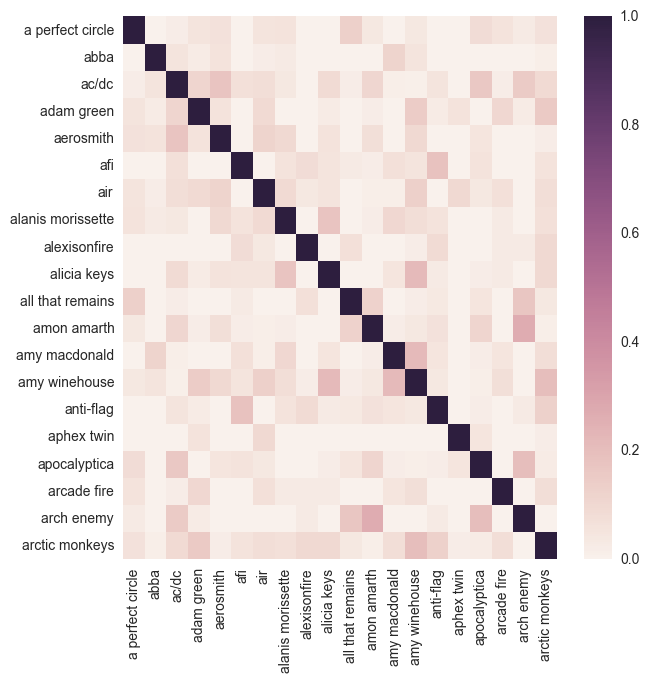

In [15]:
import seaborn as sns
plt.figure(figsize=(7,7))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [16]:
# Create a placeholder items for closes neighbours to an item
data_neighbours = pd.DataFrame(index=df_items.columns,columns=range(1,11))
 
# Loop through our similarity dataframe and fill in neighbouring item names
for i in range(0,len(df_items.columns)):
    data_neighbours.ix[i,:10] = df_items.ix[0:,i].order(ascending=False)[:10].index
 

In [17]:
data_neighbours.head(6).ix[:6,2:4]

,2,3,4
a perfect circle,tool,dredg,deftones
abba,madonna,robbie williams,elvis presley
ac/dc,red hot chili peppers,metallica,iron maiden
adam green,the libertines,the strokes,babyshambles
aerosmith,u2,led zeppelin,metallica
afi,funeral for a friend,rise against,fall out boy


## User/User based collaborative filtering

In [18]:
df.head()

,user,a perfect circle,abba,ac/dc,adam green,aerosmith,afi,air,alanis morissette,alexisonfire,alicia keys,all that remains,amon amarth,amy macdonald,amy winehouse,anti-flag,aphex twin,apocalyptica,arcade fire,arch enemy,arctic monkeys,as i lay dying,atb,atreyu,audioslave,avril lavigne,babyshambles,bad religion,beastie boys,beatsteaks,beck,beirut,belle and sebastian,beyonce,billy talent,bjork,black eyed peas,black sabbath,blind guardian,blink-182,bloc party,bloodhound gang,blur,boards of canada,bob dylan,bob marley,bob marley & the wailers,breaking benjamin,bright eyes,bring me the horizon,britney spears,bruce springsteen,bullet for my valentine,caliban,cascada,cat power,children of bodom,chimaira,christina aguilera,clueso,cocorosie,coldplay,crystal castles,cypress hill,daft punk,damien rice,dark tranquillity,david bowie,david guetta,death cab for cutie,deep purple,deftones,deichkind,depeche mode,dido,die apokalyptischen reiter,die toten hosen,digitalism,dimmu borgir,dire straits,disturbed,dream theater,dredg,dropkick murphys,duffy,editors,eels,elliott smith,eluveitie,elvis presley,eminem,ensiferum,enter shikari,equilibrium,eric clapton,evanescence,faithless,fall out boy,farin urlaub,feist,finntroll,flogging molly,flyleaf,foo fighters,frank sinatra,franz ferdinand,funeral for a friend,genesis,gentleman,godsmack,goldfrapp,good charlotte,gorillaz,green day,groove coverage,guano apes,guns n roses,hammerfall,hans zimmer,hatebreed,heaven shall burn,him,hoobastank,hot chip,howard shore,in extremo,in flames,incubus,interpol,iron maiden,jack johnson,james blunt,james morrison,jamiroquai,jason mraz,jay-z,jimi hendrix,jimmy eat world,johnny cash,jose gonzalez,joy division,judas priest,justice,justin timberlake,kaiser chiefs,kanye west,kate nash,katie melua,katy perry,keane,kelly clarkson,killswitch engage,kings of convenience,kings of leon,korpiklaani,kreator,lacuna coil,lady gaga,led zeppelin,lenny kravitz,leona lewis,lily allen,limp bizkit,linkin park,lostprophets,machine head,madonna,mando diao,manowar,manu chao,maria mena,marilyn manson,massive attack,metallica,mgmt,michael jackson,mika,millencolin,misfits,moby,modest mouse,mogwai,morcheeba,motorhead,muse,my chemical romance,nada surf,nelly furtado,nickelback,nightwish,nine inch nails,nirvana,nofx,norah jones,nouvelle vague,oasis,oomph!,opeth,panic at the disco,papa roach,paramore,parkway drive,pearl jam,peter fox,pink,pink floyd,placebo,porcupine tree,portishead,queen,queens of the stone age,r.e.m.,radiohead,rage against the machine,rammstein,ramones,razorlight,red hot chili peppers,regina spektor,rihanna,rise against,rob zombie,robbie williams,schandmaul,scooter,seeed,seether,serj tankian,silverstein,simple plan,slayer,slipknot,snow patrol,soilwork,sonata arctica,sonic syndicate,staind,stars,stone sour,subway to sally,sufjan stevens,sum 41,system of a down,tegan and sara,tenacious d,the beatles,the chemical brothers,the clash,the cure,the decemberists,the doors,the fratellis,the fray,the hives,the killers,the kooks,the libertines,the national,the notwist,the offspring,the postal service,the prodigy,the pussycat dolls,the rolling stones,the shins,the smashing pumpkins,the smiths,the streets,the strokes,the subways,the ting tings,the used,the white stripes,the wombats,thievery corporation,three days grace,timbaland,tom waits,tool,tori amos,travis,trivium,u2,underoath,volbeat,yann tiersen
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

In [19]:
df_users.head()

,1,33,42,51,62,75,130,141,144,150,205,247,256,299,313,319,336,367,371,383,422,428,438,447,458,472,477,504,508,543,584,613,626,642,644,648,683,691,715,736,792,794,830,852,876,890,906,914,915,917,925,948,951,953,956,971,972,975,978,1022,1037,1083,1117,1121,1135,1144,1174,1179,1185,1201,1207,1233,1253,1259,1264,1291,1310,1311,1327,1334,1336,1361,1376,1381,1444,1478,1479,1487,1501,1509,1521,1530,1536,1545,1549,1566,1586,1589,1601,1606,1611,1624,1627,1646,1656,1661,1680,1681,1688,1695,1718,1727,1728,1732,1758,1767,1796,1806,1807,1811,1830,1849,1856,1900,1934,1941,1943,2015,2019,2030,2044,2067,2079,2091,2099,2102,2150,2162,2172,2174,2182,2186,2195,2201,2236,2245,2266,2269,2273,2291,2304,2320,2360,2363,2373,2379,2389,2410,2425,2465,2494,2516,2579,2630,2652,2654,2657,2697,2701,2710,2761,2773,2784,2790,2843,2864,2902,2912,2936,2948,2955,2958,2963,2966,2969,3027,3050,3054,3055,3058,3060,3062,3066,3076,3083,3123,3153,3156,3164,3180,3201,3205,3255,3265,3268,3281,3322,3347,3351,3360,3362,3376,3377,3380,3385,3392,3409,3468,3482,3506,3508,3519,3547,3552,3553,3557,3574,3598,3605,3634,3638,3663,3688,3693,3706,3720,3723,3729,3740,3757,3765,3799,3882,3891,3903,3945,3958,3963,3966,3990,...,16011,16016,16025,16038,16046,16057,16084,16090,16098,16107,16111,16125,16127,16133,16164,16171,16172,16187,16200,16216,16234,16241,16271,16284,16293,16294,16308,16331,16355,16357,16363,16377,16388,16411,16421,16433,16448,16469,16472,16474,16495,16535,16583,16602,16604,16612,16624,16628,16629,16651,16653,16654,16668,16673,16681,16701,16717,16718,16745,16747,16754,16779,16811,16860,16872,16918,16942,16951,16970,16988,17017,17050,17062,17080,17101,17110,17127,17155,17163,17172,17182,17215,17219,17220,17231,17233,17251,17254,17288,17318,17347,17360,17361,17396,17415,17420,17425,17433,17434,17437,17443,17454,17463,17467,17468,17481,17482,17510,17513,17533,17538,17585,17589,17595,17623,17631,17635,17656,17657,17666,17701,17713,17720,17723,17741,17747,17751,17787,17806,17821,17827,17835,17854,17865,17879,17882,17916,17948,17979,17982,17999,18014,18030,18048,18068,18076,18082,18085,18093,18097,18098,18142,18221,18257,18274,18278,18302,18312,18334,18348,18355,18379,18384,18427,18439,18447,18451,18490,18523,18529,18538,18540,18559,18593,18601,18623,18631,18634,18652,18666,18669,18681,18715,18719,18724,18725,18730,18736,18765,18768,18779,18790,18795,18804,18816,18847,18870,18879,18905,18934,18949,18957,18961,18983,18994,18999,19012,19024,19040,19043,19049,19071,19090,19101,19103,19111,19135,19167,19182,19202,19207,19213,19227,19236,19262,19278,19329,19359,19384,19398,19439,19441,19470,19472,19474,19499,19501,19515,19521,19565,19581,19596,19623,19629,19637,19639,19642,19662,19672,19695
1,1.000000,0.061546,0.000000,0.000000,0.083624,0.000000,0,0.000000,0.000000,0.150756,0.226134,0.000000,0.000000,0.000000,0.000000,0.064282,0.064282,0.090909,0,0.000000,0.061546,0.058026,0.080582,0,0.000000,0.000000,0.062869,0.128565,0.080582,0.067420,0.000000,0.077850,0.073127,0.000000,0,0.146254,0,0,0.123091,0.000000,0,0.073127,0.000000,0.106600,0,0.000000,0.123091,0,0.000000,0.000000,0.000000,0.073127,0.000000,0.090909,0.000000,0,0.052486,0.155700,0.095346,0.118262,0.000000,0,0,0.181818,0.065795,0.083624,0.064282,0.000000,0,0.134840,0.087039,0.000000,0.054153,0.226134,0.000000,0.000000,0.000000,0.075378,0.00000,0,0,0.000000,0.128565,0.000000,0.000000,0,0.161165,0.000000,0,0.087039,0.1066,0,0.000000,0.190693,0.000000,0,0.000000,0.000000,0.000000,0,0.000000,0.071067,0.000000,0,0,0.000000,0.000000,0.125739,0.000000,0,0.000000,0,0,0,0.00000,0.146254,0.000000,0,0.064282,0,0.000000,0.075378,0.095346,0,0.095346,0.000000,0.207514,0.000000,0.155700,0,0.000000,0.073127,0.000000,0.000000,0.131590,0.000000,0.123091,0.000000,0.090909,0.138343,0.181818,0,0.000000,0,0,0.000000,0.101929,0.000000,0.080582,0.000000,0.000000,0.075378,0.000000,0.000000,0.060302,0.167968,0.000000,0.064282,0.000000,0.000000,0.181818,0.000000,0.246183,0.090909,0,0.000000,0.118262,0.111979,0,0.000000,0.000000,0.113961,0.064282,0

In [20]:
df_users[0:10][df_users.columns[0:10]]

,1,33,42,51,62,75,130,141,144,150
1,1.000000,0.061546,0.000000,0.000000,0.083624,0.000000,0,0.000000,0.000000,0.150756
33,0.061546,1.000000,0.077152,0.247537,0.226455,0.176777,0,0.000000,0.000000,0.102062
42,0.000000,0.077152,1.000000,0.000000,0.000000,0.000000,0,0.091670,0.000000,0.000000
51,0.000000,0.247537,0.000000,1.000000,0.336336,0.140028,0,0.000000,0.108465,0.121268
62,0.083624,0.226455,0.000000,0.336336,1.000000,0.160128,0,0.067267,0.124035,0.138675
75,0.000000,0.176777,0.000000,0.140028,0.160128,1.000000,0,0.000000,0.000000,0.000000
130,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1,0.000000,0.000000,0.000000
141,0.000000,0.000000,0.091670,0.000000,0.067267,0.000000,0,1.000000,0.000000,0.000000
144,0.000000,0.000000,0.000000,0.108465,0.124035,0.000000,0,0.000000,1.000000,0.000000
150,0.150756,0.102062,0.000000,0.121268,0.138675,0.000000,0,0.000000,0.000000,1.000000


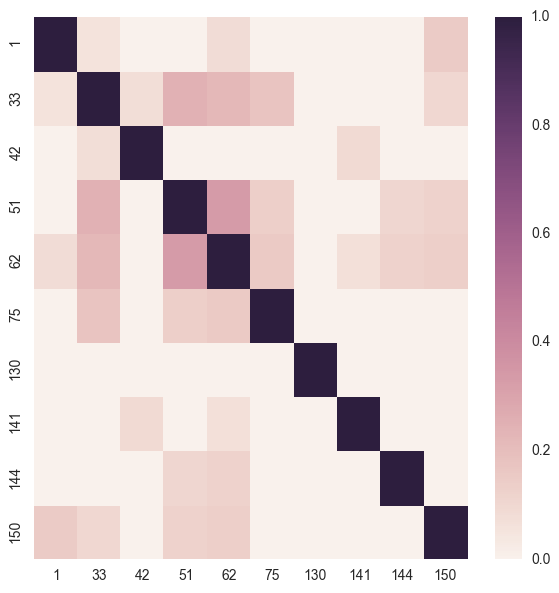

In [21]:
import seaborn as sns
corr = df_users[0:10][df_users.columns[0:10]]
plt.figure(figsize=(7,7))
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [22]:
users=df['user'].values

In [23]:
df_user_recs=df_users.apply(lambda row : users[np.argsort(row)[::-1]],axis=1)

In [24]:
df_nearest_neighbors_all=df_user_recs[df_user_recs.columns[0:]]

In [25]:
df_nearest_neighbors_5 = df_nearest_neighbors_all[df_nearest_neighbors_all.columns[0:5]]

In [26]:
df_nearest_neighbors_5.head()

,1,33,42,51,62
1,1,16779,17415,9881,14558
33,33,9227,7092,16421,16811
42,42,19207,5574,3958,16098
51,51,19071,14712,17231,3377
62,62,16754,458,3377,19071


In [27]:
df.head()

,user,a perfect circle,abba,ac/dc,adam green,aerosmith,afi,air,alanis morissette,alexisonfire,alicia keys,all that remains,amon amarth,amy macdonald,amy winehouse,anti-flag,aphex twin,apocalyptica,arcade fire,arch enemy,arctic monkeys,as i lay dying,atb,atreyu,audioslave,avril lavigne,babyshambles,bad religion,beastie boys,beatsteaks,beck,beirut,belle and sebastian,beyonce,billy talent,bjork,black eyed peas,black sabbath,blind guardian,blink-182,bloc party,bloodhound gang,blur,boards of canada,bob dylan,bob marley,bob marley & the wailers,breaking benjamin,bright eyes,bring me the horizon,britney spears,bruce springsteen,bullet for my valentine,caliban,cascada,cat power,children of bodom,chimaira,christina aguilera,clueso,cocorosie,coldplay,crystal castles,cypress hill,daft punk,damien rice,dark tranquillity,david bowie,david guetta,death cab for cutie,deep purple,deftones,deichkind,depeche mode,dido,die apokalyptischen reiter,die toten hosen,digitalism,dimmu borgir,dire straits,disturbed,dream theater,dredg,dropkick murphys,duffy,editors,eels,elliott smith,eluveitie,elvis presley,eminem,ensiferum,enter shikari,equilibrium,eric clapton,evanescence,faithless,fall out boy,farin urlaub,feist,finntroll,flogging molly,flyleaf,foo fighters,frank sinatra,franz ferdinand,funeral for a friend,genesis,gentleman,godsmack,goldfrapp,good charlotte,gorillaz,green day,groove coverage,guano apes,guns n roses,hammerfall,hans zimmer,hatebreed,heaven shall burn,him,hoobastank,hot chip,howard shore,in extremo,in flames,incubus,interpol,iron maiden,jack johnson,james blunt,james morrison,jamiroquai,jason mraz,jay-z,jimi hendrix,jimmy eat world,johnny cash,jose gonzalez,joy division,judas priest,justice,justin timberlake,kaiser chiefs,kanye west,kate nash,katie melua,katy perry,keane,kelly clarkson,killswitch engage,kings of convenience,kings of leon,korpiklaani,kreator,lacuna coil,lady gaga,led zeppelin,lenny kravitz,leona lewis,lily allen,limp bizkit,linkin park,lostprophets,machine head,madonna,mando diao,manowar,manu chao,maria mena,marilyn manson,massive attack,metallica,mgmt,michael jackson,mika,millencolin,misfits,moby,modest mouse,mogwai,morcheeba,motorhead,muse,my chemical romance,nada surf,nelly furtado,nickelback,nightwish,nine inch nails,nirvana,nofx,norah jones,nouvelle vague,oasis,oomph!,opeth,panic at the disco,papa roach,paramore,parkway drive,pearl jam,peter fox,pink,pink floyd,placebo,porcupine tree,portishead,queen,queens of the stone age,r.e.m.,radiohead,rage against the machine,rammstein,ramones,razorlight,red hot chili peppers,regina spektor,rihanna,rise against,rob zombie,robbie williams,schandmaul,scooter,seeed,seether,serj tankian,silverstein,simple plan,slayer,slipknot,snow patrol,soilwork,sonata arctica,sonic syndicate,staind,stars,stone sour,subway to sally,sufjan stevens,sum 41,system of a down,tegan and sara,tenacious d,the beatles,the chemical brothers,the clash,the cure,the decemberists,the doors,the fratellis,the fray,the hives,the killers,the kooks,the libertines,the national,the notwist,the offspring,the postal service,the prodigy,the pussycat dolls,the rolling stones,the shins,the smashing pumpkins,the smiths,the streets,the strokes,the subways,the ting tings,the used,the white stripes,the wombats,thievery corporation,three days grace,timbaland,tom waits,tool,tori amos,travis,trivium,u2,underoath,volbeat,yann tiersen
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,33,0,0,0,1,0,0,0,0,0,0,0,0,0,0,

In [29]:
def get_artists_from_user(user_row):
    suggested_likes = df_items.columns.values[np.where(df[df['user'].isin(user_row.values)]!=0)[1][1:]] #df[df['user'].isin(user_row)]
    user_likes = df.columns[np.where(df[df['user']==user_row.values[0]].values!=0)[1]].values[1:]
    suggestions= [s for s in suggested_likes if s not in user_likes]
    return suggestions[0:5]

df_nearest_neighbors_5[0:5].apply(lambda row : get_artists_from_user(row),axis=1)

,1,33,42,51,62
1,duffy,elvis presley,good charlotte,guns n roses,james blunt
33,aerosmith,beyonce,cocorosie,crystal castles,deep purple
42,atb,babyshambles,faithless,guano apes,hoobastank
51,as i lay dying,beck,bjork,cocorosie,editors
62,beck,bjork,bloc party,cocorosie,depeche mode


In [30]:
df_items

,a perfect circle,abba,ac/dc,adam green,aerosmith,afi,air,alanis morissette,alexisonfire,alicia keys,all that remains,amon amarth,amy macdonald,amy winehouse,anti-flag,aphex twin,apocalyptica,arcade fire,arch enemy,arctic monkeys,as i lay dying,atb,atreyu,audioslave,avril lavigne,babyshambles,bad religion,beastie boys,beatsteaks,beck,beirut,belle and sebastian,beyonce,billy talent,bjork,black eyed peas,black sabbath,blind guardian,blink-182,bloc party,bloodhound gang,blur,boards of canada,bob dylan,bob marley,bob marley & the wailers,breaking benjamin,bright eyes,bring me the horizon,britney spears,bruce springsteen,bullet for my valentine,caliban,cascada,cat power,children of bodom,chimaira,christina aguilera,clueso,cocorosie,coldplay,crystal castles,cypress hill,daft punk,damien rice,dark tranquillity,david bowie,david guetta,death cab for cutie,deep purple,deftones,deichkind,depeche mode,dido,die apokalyptischen reiter,die toten hosen,digitalism,dimmu borgir,dire straits,disturbed,dream theater,dredg,dropkick murphys,duffy,editors,eels,elliott smith,eluveitie,elvis presley,eminem,ensiferum,enter shikari,equilibrium,eric clapton,evanescence,faithless,fall out boy,farin urlaub,feist,finntroll,flogging molly,flyleaf,foo fighters,frank sinatra,franz ferdinand,funeral for a friend,genesis,gentleman,godsmack,goldfrapp,good charlotte,gorillaz,green day,groove coverage,guano apes,guns n roses,hammerfall,hans zimmer,hatebreed,heaven shall burn,him,hoobastank,hot chip,howard shore,in extremo,in flames,incubus,interpol,iron maiden,jack johnson,james blunt,james morrison,jamiroquai,jason mraz,jay-z,jimi hendrix,jimmy eat world,johnny cash,jose gonzalez,joy division,judas priest,justice,justin timberlake,kaiser chiefs,kanye west,kate nash,katie melua,katy perry,keane,kelly clarkson,killswitch engage,kings of convenience,kings of leon,korpiklaani,kreator,lacuna coil,lady gaga,led zeppelin,lenny kravitz,leona lewis,lily allen,limp bizkit,linkin park,lostprophets,machine head,madonna,mando diao,manowar,manu chao,maria mena,marilyn manson,massive attack,metallica,mgmt,michael jackson,mika,millencolin,misfits,moby,modest mouse,mogwai,morcheeba,motorhead,muse,my chemical romance,nada surf,nelly furtado,nickelback,nightwish,nine inch nails,nirvana,nofx,norah jones,nouvelle vague,oasis,oomph!,opeth,panic at the disco,papa roach,paramore,parkway drive,pearl jam,peter fox,pink,pink floyd,placebo,porcupine tree,portishead,queen,queens of the stone age,r.e.m.,radiohead,rage against the machine,rammstein,ramones,razorlight,red hot chili peppers,regina spektor,rihanna,rise against,rob zombie,robbie williams,schandmaul,scooter,seeed,seether,serj tankian,silverstein,simple plan,slayer,slipknot,snow patrol,soilwork,sonata arctica,sonic syndicate,staind,stars,stone sour,subway to sally,sufjan stevens,sum 41,system of a down,tegan and sara,tenacious d,the beatles,the chemical brothers,the clash,the cure,the decemberists,the doors,the fratellis,the fray,the hives,the killers,the kooks,the libertines,the national,the notwist,the offspring,the postal service,the prodigy,the pussycat dolls,the rolling stones,the shins,the smashing pumpkins,the smiths,the streets,the strokes,the subways,the ting tings,the used,the white stripes,the wombats,thievery corporation,three days grace,timbaland,tom waits,tool,tori amos,travis,trivium,u2,underoath,volbeat,yann tiersen
a perfect circle,1.000000,0.000000,0.017917,0.051554,0.062776,0.000000,0.051755,0.060718,0.000000,0.000000,0.130120,0.042934,0.000000,0.036037,0.000000,0.000000,0.085868,0.056344,0.029881,0.063888,0.087287,0.000000,0.024656,0.117698,0.000000,0.000000,0.023669,0.000000,0.046881,0.025482,0.000000,0.028172,0.000000,0.102986,0.000000,0.025482,0.027067,0.022195,0.036886,0.113855,0.024147,0.000000,0.059761,0.000000,0.041301,0.029881,0.047338,0.085714,0.000000,0.000000,0.000000,0.145817,0.117698,0.000000,0.031944,0.043284,0.033150,0.000000,0.016988,0.000000,0.096344,0.000000,0.000000,0.019017,0.000000,0.031388,0

# Model Scoring - Splitting into Training and Testing

In [263]:
item_item = 1-pairwise_distances(X[0:1000].T, metric="cosine")
df_items = pd.DataFrame(item_item,columns=X.columns,index=X.columns)

In [264]:
df_items

,a perfect circle,abba,ac/dc,adam green,aerosmith,afi,air,alanis morissette,alexisonfire,alicia keys,all that remains,amon amarth,amy macdonald,amy winehouse,anti-flag,aphex twin,apocalyptica,arcade fire,arch enemy,arctic monkeys,as i lay dying,atb,atreyu,audioslave,avril lavigne,babyshambles,bad religion,beastie boys,beatsteaks,beck,beirut,belle and sebastian,beyonce,billy talent,bjork,black eyed peas,black sabbath,blind guardian,blink-182,bloc party,bloodhound gang,blur,boards of canada,bob dylan,bob marley,bob marley & the wailers,breaking benjamin,bright eyes,bring me the horizon,britney spears,bruce springsteen,bullet for my valentine,caliban,cascada,cat power,children of bodom,chimaira,christina aguilera,clueso,cocorosie,coldplay,crystal castles,cypress hill,daft punk,damien rice,dark tranquillity,david bowie,david guetta,death cab for cutie,deep purple,deftones,deichkind,depeche mode,dido,die apokalyptischen reiter,die toten hosen,digitalism,dimmu borgir,dire straits,disturbed,dream theater,dredg,dropkick murphys,duffy,editors,eels,elliott smith,eluveitie,elvis presley,eminem,ensiferum,enter shikari,equilibrium,eric clapton,evanescence,faithless,fall out boy,farin urlaub,feist,finntroll,flogging molly,flyleaf,foo fighters,frank sinatra,franz ferdinand,funeral for a friend,genesis,gentleman,godsmack,goldfrapp,good charlotte,gorillaz,green day,groove coverage,guano apes,guns n roses,hammerfall,hans zimmer,hatebreed,heaven shall burn,him,hoobastank,hot chip,howard shore,in extremo,in flames,incubus,interpol,iron maiden,jack johnson,james blunt,james morrison,jamiroquai,jason mraz,jay-z,jimi hendrix,jimmy eat world,johnny cash,jose gonzalez,joy division,judas priest,justice,justin timberlake,kaiser chiefs,kanye west,kate nash,katie melua,katy perry,keane,kelly clarkson,killswitch engage,kings of convenience,kings of leon,korpiklaani,kreator,lacuna coil,lady gaga,led zeppelin,lenny kravitz,leona lewis,lily allen,limp bizkit,linkin park,lostprophets,machine head,madonna,mando diao,manowar,manu chao,maria mena,marilyn manson,massive attack,metallica,mgmt,michael jackson,mika,millencolin,misfits,moby,modest mouse,mogwai,morcheeba,motorhead,muse,my chemical romance,nada surf,nelly furtado,nickelback,nightwish,nine inch nails,nirvana,nofx,norah jones,nouvelle vague,oasis,oomph!,opeth,panic at the disco,papa roach,paramore,parkway drive,pearl jam,peter fox,pink,pink floyd,placebo,porcupine tree,portishead,queen,queens of the stone age,r.e.m.,radiohead,rage against the machine,rammstein,ramones,razorlight,red hot chili peppers,regina spektor,rihanna,rise against,rob zombie,robbie williams,schandmaul,scooter,seeed,seether,serj tankian,silverstein,simple plan,slayer,slipknot,snow patrol,soilwork,sonata arctica,sonic syndicate,staind,stars,stone sour,subway to sally,sufjan stevens,sum 41,system of a down,tegan and sara,tenacious d,the beatles,the chemical brothers,the clash,the cure,the decemberists,the doors,the fratellis,the fray,the hives,the killers,the kooks,the libertines,the national,the notwist,the offspring,the postal service,the prodigy,the pussycat dolls,the rolling stones,the shins,the smashing pumpkins,the smiths,the streets,the strokes,the subways,the ting tings,the used,the white stripes,the wombats,thievery corporation,three days grace,timbaland,tom waits,tool,tori amos,travis,trivium,u2,underoath,volbeat,yann tiersen
a perfect circle,1.000000,0.000000,0.022917,0.066815,0.038576,0.000000,0.044237,0.075593,0.000000,0.000000,0.120873,0.000000,0.000000,0.023088,0.000000,0.000000,0.080992,0.034503,0.000000,0.078811,0.087482,0.000000,0.031497,0.111187,0.000000,0.000000,0.031068,0.000000,0.059108,0.000000,0.000000,0.000000,0.000000,0.094491,0.000000,0.032410,0.034503,0.027864,0.044544,0.145204,0.029161,0.000000,0.078811,0.000000,0.051434,0.037796,0.055728,0.111187,0.000000,0.000000,0.000000,0.137505,0.148250,0.000000,0.039406,0.000000,0.040291,0.000000,0.000000,0.000000,0.106600,0.000000,0.000000,0.023440,0.000000,0.039406,0

In [265]:
df_items.shape

(285, 285)

# Computing recall over testing data 

In [194]:
import random
random.sample(user_201_prefs_2, min(guesses,len(user_201_prefs_2)))

['norah jones', 'elvis presley']

(1257, 285)

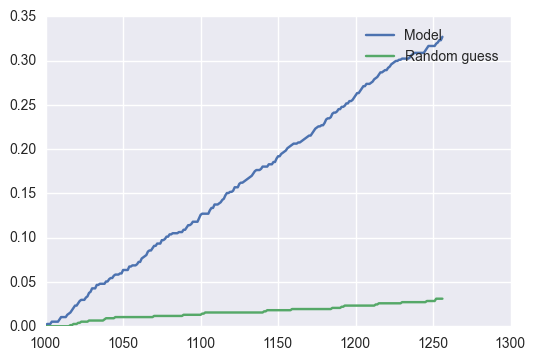

In [294]:
recall=[]
guesses = 3
recall_total = 0
recall_guess = 0

recall_guesses = []

for n in range(1000,1257):
    user = np.append(X[n:n+1].values[0][0:200],np.zeros(85))
    user_prefs = df_items.dot(user/np.sum(user))
    
    user_prefs.sort()
    already_liked=df_items[df_items.columns[np.where(X[n:n+1].values[0]>0)][0:5]].columns.values

    test_data=df_items[df_items.columns[np.where(X[n:n+1].values[0]>0)][5:]].columns.values
    
    user_suggestions =[s for s in user_prefs.index[::-1][0:guesses] if s not in already_liked]
    
    correct = [c for c in user_suggestions if c in test_data]
    guess_list = [g for g in random.sample(user_prefs.index, min(guesses,len(user_prefs))) if g in test_data]

    recall_total = recall_total + float(len(correct))
    recall_guess = recall_guess + float(len(guess_list))
   
    recall.append(recall_total)
    recall_guesses.append(recall_guess)
plt.plot(range(1000,1257),recall/(np.array(guesses)*257),label='Model')
plt.plot(range(1000,1257),recall_guesses/(np.array(guesses)*257),label='Random guess')
plt.legend()

# Graph Diffusion

In [261]:
df=X[0:]
M = df.div(df.sum(axis=1), axis=0)
G = df/df.sum().astype(np.float64)

In [262]:
G.T.shape

(285, 200)

In [244]:
M.shape


(1257, 285)

In [256]:
G.T.shape

(285, 1257)

In [257]:
M.shape

(1257, 285)

In [259]:
A = pd.DataFrame(G.values*M.values, columns=df.columns, index=df.index)

In [260]:
A.head()gu

,a perfect circle,abba,ac/dc,adam green,aerosmith,afi,air,alanis morissette,alexisonfire,alicia keys,all that remains,amon amarth,amy macdonald,amy winehouse,anti-flag,aphex twin,apocalyptica,arcade fire,arch enemy,arctic monkeys,as i lay dying,atb,atreyu,audioslave,avril lavigne,babyshambles,bad religion,beastie boys,beatsteaks,beck,beirut,belle and sebastian,beyonce,billy talent,bjork,black eyed peas,black sabbath,blind guardian,blink-182,bloc party,bloodhound gang,blur,boards of canada,bob dylan,bob marley,bob marley & the wailers,breaking benjamin,bright eyes,bring me the horizon,britney spears,bruce springsteen,bullet for my valentine,caliban,cascada,cat power,children of bodom,chimaira,christina aguilera,clueso,cocorosie,coldplay,crystal castles,cypress hill,daft punk,damien rice,dark tranquillity,david bowie,david guetta,death cab for cutie,deep purple,deftones,deichkind,depeche mode,dido,die apokalyptischen reiter,die toten hosen,digitalism,dimmu borgir,dire straits,disturbed,dream theater,dredg,dropkick murphys,duffy,editors,eels,elliott smith,eluveitie,elvis presley,eminem,ensiferum,enter shikari,equilibrium,eric clapton,evanescence,faithless,fall out boy,farin urlaub,feist,finntroll,flogging molly,flyleaf,foo fighters,frank sinatra,franz ferdinand,funeral for a friend,genesis,gentleman,godsmack,goldfrapp,good charlotte,gorillaz,green day,groove coverage,guano apes,guns n roses,hammerfall,hans zimmer,hatebreed,heaven shall burn,him,hoobastank,hot chip,howard shore,in extremo,in flames,incubus,interpol,iron maiden,jack johnson,james blunt,james morrison,jamiroquai,jason mraz,jay-z,jimi hendrix,jimmy eat world,johnny cash,jose gonzalez,joy division,judas priest,justice,justin timberlake,kaiser chiefs,kanye west,kate nash,katie melua,katy perry,keane,kelly clarkson,killswitch engage,kings of convenience,kings of leon,korpiklaani,kreator,lacuna coil,lady gaga,led zeppelin,lenny kravitz,leona lewis,lily allen,limp bizkit,linkin park,lostprophets,machine head,madonna,mando diao,manowar,manu chao,maria mena,marilyn manson,massive attack,metallica,mgmt,michael jackson,mika,millencolin,misfits,moby,modest mouse,mogwai,morcheeba,motorhead,muse,my chemical romance,nada surf,nelly furtado,nickelback,nightwish,nine inch nails,nirvana,nofx,norah jones,nouvelle vague,oasis,oomph!,opeth,panic at the disco,papa roach,paramore,parkway drive,pearl jam,peter fox,pink,pink floyd,placebo,porcupine tree,portishead,queen,queens of the stone age,r.e.m.,radiohead,rage against the machine,rammstein,ramones,razorlight,red hot chili peppers,regina spektor,rihanna,rise against,rob zombie,robbie williams,schandmaul,scooter,seeed,seether,serj tankian,silverstein,simple plan,slayer,slipknot,snow patrol,soilwork,sonata arctica,sonic syndicate,staind,stars,stone sour,subway to sally,sufjan stevens,sum 41,system of a down,tegan and sara,tenacious d,the beatles,the chemical brothers,the clash,the cure,the decemberists,the doors,the fratellis,the fray,the hives,the killers,the kooks,the libertines,the national,the notwist,the offspring,the postal service,the prodigy,the pussycat dolls,the rolling stones,the shins,the smashing pumpkins,the smiths,the streets,the strokes,the subways,the ting tings,the used,the white stripes,the wombats,thievery corporation,three days grace,timbaland,tom waits,tool,tori amos,travis,trivium,u2,underoath,volbeat,yann tiersen
0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,0,0,0,0.000000,0,0,0,0.000000,0,0,0.000000,0,0.000000,0,0,0,0,0.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0,0.000000,0,0,0,0,0,0,0,0.000000,0,0,0.000000,0,0,0,0.000000,0,0,0,0,0,0,0.001783,0.000000,0,0,0,0.002331,0,0,0,0,0,0,0.000000,0,0,0.000000,0,0,0,0,0.000000,0,0,0,0,0,0,0.002217,0,0,0,0.000000,0.00303,0,0,0,0,0,0.00000,0,0,0,0.000000,0,0.000000,0,0,0.000745,0,0,0,0,0,0,0,0,0,0,0.002597,0,0.000000,0,0.00000,0.000000,0,0,0.000000,0,0,0,0.000000,0,0,0,0,0,0,0,0.000000,0,0.00000,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0,

In [298]:
B=(A)**30

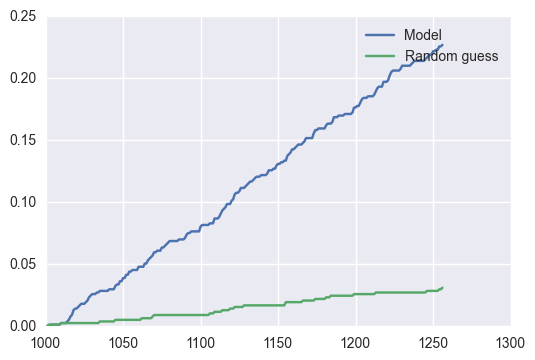

In [299]:
recall=[]
guesses = 3
recall_total = 0
recall_guess = 0

recall_guesses = []

for n in range(1000,1257):
    user = np.append(B[n:n+1].values[0][0:200],np.zeros(85))
    user_prefs = df_items.dot(user/np.sum(user))
    
    user_prefs.sort()
    already_liked=df_items[df_items.columns[np.where(B[n:n+1].values[0]>0)][0:5]].columns.values

    test_data=df_items[df_items.columns[np.where(B[n:n+1].values[0]>0)][5:]].columns.values
    
    user_suggestions =[s for s in user_prefs.index[::-1][0:guesses] if s not in already_liked]
    
    correct = [c for c in user_suggestions if c in test_data]
    guess_list = [g for g in random.sample(user_prefs.index, min(guesses,len(user_prefs))) if g in test_data]

    recall_total = recall_total + float(len(correct))
    recall_guess = recall_guess + float(len(guess_list))
   
    recall.append(recall_total)
    recall_guesses.append(recall_guess)
plt.plot(range(1000,1257),recall/(np.array(guesses)*257),label='Model')
plt.plot(range(1000,1257),recall_guesses/(np.array(guesses)*257),label='Random guess')
plt.legend()

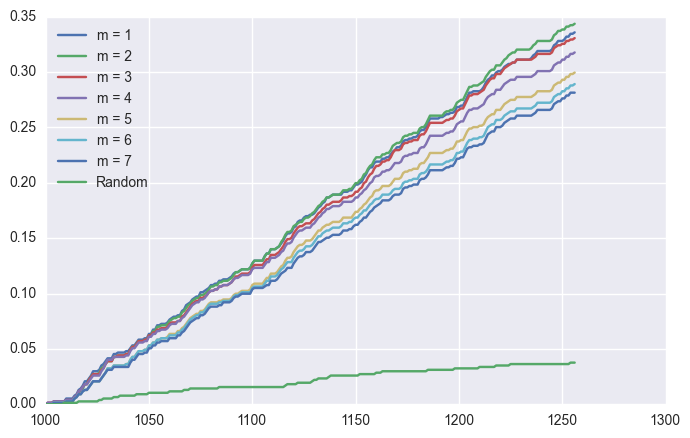

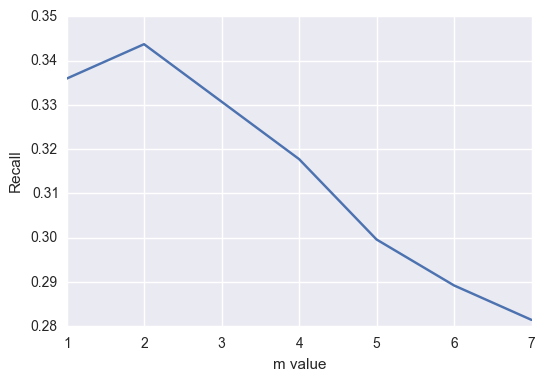

In [332]:
best_m=1
recall_last = 0
plt.figure(figsize=(8,5))
recall_m= []
mvals=[1,2,3,4,5,6,7]
for m in mvals:
    B = (A)**m
    recall=[]
    guesses = 3
    recall_total = 0
    recall_guess = 0

    recall_guesses = []

    for n in range(1000,1257):
        user = np.append(B[n:n+1].values[0][0:200],np.zeros(85))
        user_prefs = df_items.dot(user/np.sum(user))

        user_prefs.sort()
        already_liked=df_items[df_items.columns[np.where(B[n:n+1].values[0]>0)][0:5]].columns.values

        test_data=df_items[df_items.columns[np.where(B[n:n+1].values[0]>0)][5:]].columns.values

        user_suggestions =[s for s in user_prefs.index[::-1][0:guesses] if s not in already_liked]

        correct = [c for c in user_suggestions if c in test_data]
        guess_list = [g for g in random.sample(user_prefs.index, min(guesses,len(user_prefs))) if g in test_data]

        recall_total = recall_total + float(len(correct))
        recall_guess = recall_guess + float(len(guess_list))

        recall.append(recall_total)
        recall_guesses.append(recall_guess)
    
    plt.plot(range(1000,1257),recall/(np.array(guesses)*257),label='m = ' + str(m))
    if recall_total > recall_last:
        recall_last = recall_total
        best_m = m
    recall_m.append(recall_total/(guesses*257))

plt.plot(range(1000,1257),recall_guesses/(np.array(guesses)*257),label='Random')
plt.legend(loc=2)
plt.show()
#print 'The best choice of m is ' + str(best_m)
plt.ylabel('Recall')
plt.xlabel('m value')
plt.plot(mvals,recall_m)

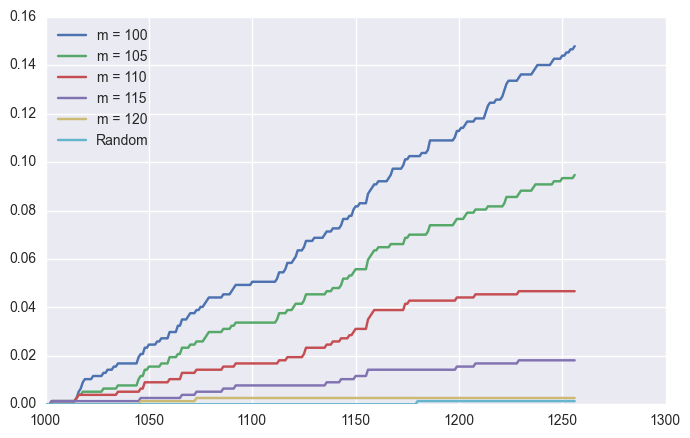

In [328]:
plt.figure(figsize=(8,5))
for m in [100, 105, 110, 115, 120]:
    B = (A)**m
    recall=[]
    guesses = 3
    recall_total = 0
    recall_guess = 0

    recall_guesses = []

    for n in range(1000,1257):
        user = np.append(B[n:n+1].values[0][0:200],np.zeros(85))
        user_prefs = df_items.dot(user/np.sum(user))

        user_prefs.sort()
        already_liked=df_items[df_items.columns[np.where(B[n:n+1].values[0]>0)][0:5]].columns.values

        test_data=df_items[df_items.columns[np.where(B[n:n+1].values[0]>0)][5:]].columns.values

        user_suggestions =[s for s in user_prefs.index[::-1][0:guesses] if s not in already_liked]

        correct = [c for c in user_suggestions if c in test_data]
        guess_list = [g for g in random.sample(user_prefs.index, min(guesses,len(user_prefs))) if g in test_data]

        recall_total = recall_total + float(len(correct))
        recall_guess = recall_guess + float(len(guess_list))

        recall.append(recall_total)
        recall_guesses.append(recall_guess)
    plt.plot(range(1000,1257),recall/(np.array(guesses)*257),label='m = ' + str(m))
    if recall_total > recall_last:
        recall_last = recall_total
        best_m = m

plt.plot(range(1000,1257),recall_guesses/(np.array(guesses)*257),label='Random')
plt.legend(loc=2)
plt.show()
#print 'The best choice of m is ' + str(best_m)
